# **Imputación de datos**
Se sustituiran los valores faltantes utilizando algoritmos de ML para predecirlos.


## Setup

In [7]:
import pandas as pd
import numpy as np
import os 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Set max columns
pd.set_option('display.max_columns', None)

DATADIR = 'data/2020/'
MODELS = 'models/'

# Set paths
DATASET = os.path.join(DATADIR, '2020pp.csv')

In [2]:
!pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
try:
    from google.colab import drive # import drive from google colab
    ROOT = "/content/drive"     # default location for the drive
    print(ROOT)                 # print content of ROOT (Optional)
    drive.mount(ROOT)           # we mount the google drive at /content/drive
    IN_COLAB = True
except:
    IN_COLAB = False

In [4]:
IN_COLAB

False

In [5]:
if IN_COLAB:
    %cd drive/MyDrive/Facultad/Tesis

In [6]:
!ls

data  DataImputation.ipynb  models  tipo.csv  Untitled0.ipynb  Untitled1.ipynb


## Carga dataset

In [8]:
df = pd.read_csv(DATASET, index_col=[0])

/usr/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,7,8,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
df

,AUDI,DECL,DPTO,ELE,GVD,INC,INOFFDPTO,INOFFUSI,LOC,MADU,PJI,RETO,TALL,TIPO,UET,ZONA
0,CAPS,2020-01-27 09:00:00.000000,NaN,4120,V2,180,NaN,NaN,NaN,NaN,655200530232,NaN,NaN,NaN,NaN,NaN
1,CAPS,2020-01-27 09:00:00.000000,NaN,4466,V2,1010,NaN,NaN,NaN,NaN,655200420197,NaN,NaN,NaN,NaN,NaN
2,CAPS,2020-01-27 09:00:00.000000,NaN,4420,V2,1110,NaN,NaN,NaN,NaN,655200450172,NaN,NaN,NaN,NaN,NaN
3,CAPS,2020-01-27 09:00:00.000000,NaN,4412,V2,1180,NaN,NaN,NaN,NaN,655200450172,NaN,NaN,NaN,NaN,NaN
4,CAPS,2020-01-27 09:00:00.000000,NaN,4414,V2,1270,NaN,NaN,NaN,NaN,655200420197,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235533,PESD,2020-12-30 09:06:00,PINT,4502,V2,1000,NaN,NaN,GRAL,NaN,655210140012,NaN,SERVP,ASP,DIP,PESD
235534,PESD,2020-12-30 10:03:00,SOLD,7887,V2,3220,NaN,NaN,NaN,NaN,655210140033,NaN,TOLE4,GMTR,659,PESD
235535,PESD,2020-12-30 10:03:00,MONT,5215,V2,4450,NaN,NaN,K74,NaN,655210140033,NaN,CH-ME,NCON,654,PESD
235536,PESD,2020-12-30 10:03:00,PINT,4401,V2,1190,NaN,NaN,H54,NaN,655210140033,NaN,PTAL2,ASP,483,PESD


# **Missing values**
Graficaremos en que columnas tenemos valores faltantes.

In [ ]:
import missingno as msno
%matplotlib inline

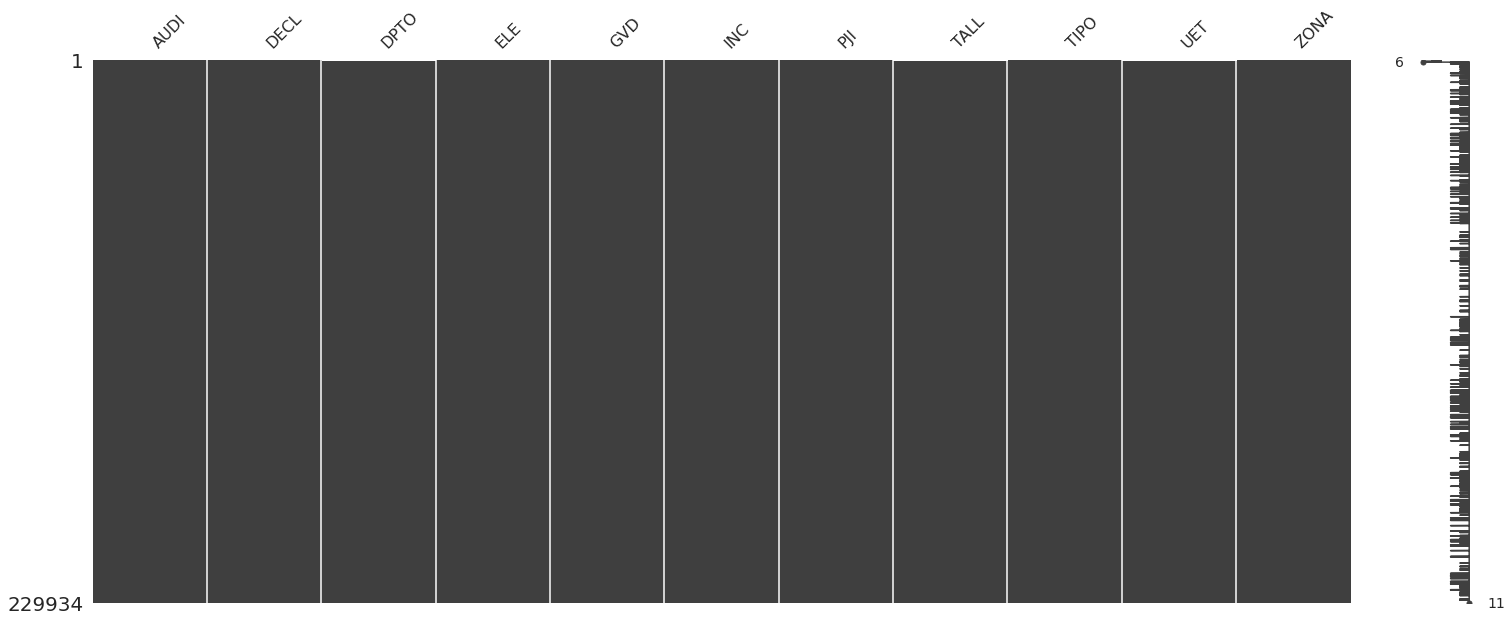

In [ ]:
msno.matrix(df.drop(columns=['LOC', 'INOFFDPTO', 'INOFFUSI','MADU','RETO']))

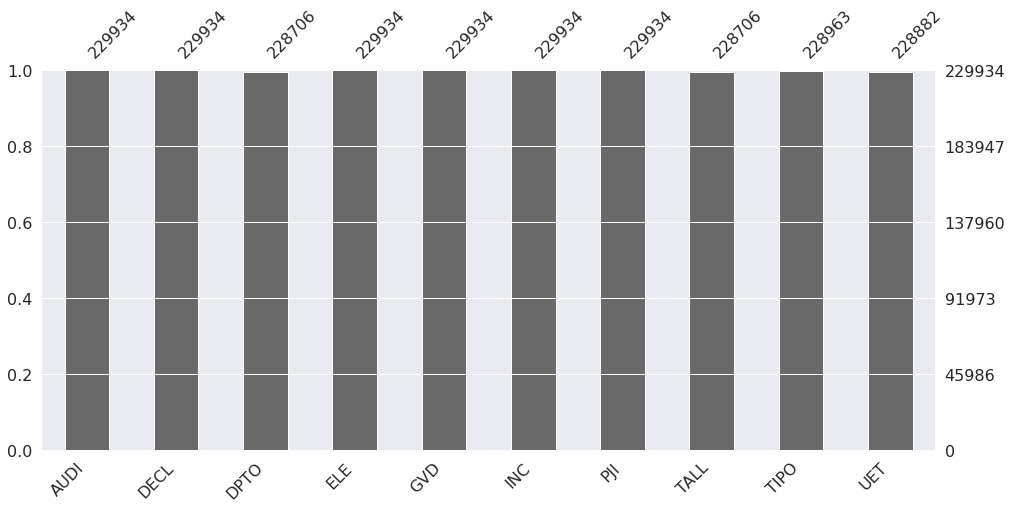

In [ ]:
msno.bar(df.drop(columns=['LOC', 'INOFFDPTO', 'INOFFUSI','MADU','RETO', 'ZONA']), figsize=(16,7))

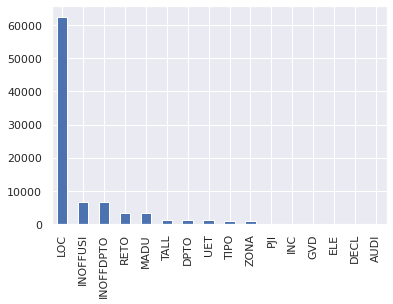

In [ ]:
df.isna().sum().sort_values(ascending=False).plot(kind='bar')

## Matriz de correlación
La correlación es una indicación de los cambios entre dos variables, nos es útil para seleccionar las *features* con la que entrenaremos los modelos.

In [ ]:
df.fillna({'LOC':'-'},inplace=True)

In [ ]:
corrmatrix = df.drop(columns=['RETO', 'MADU', 'DECL','PJI','TALL','DPTO']).apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

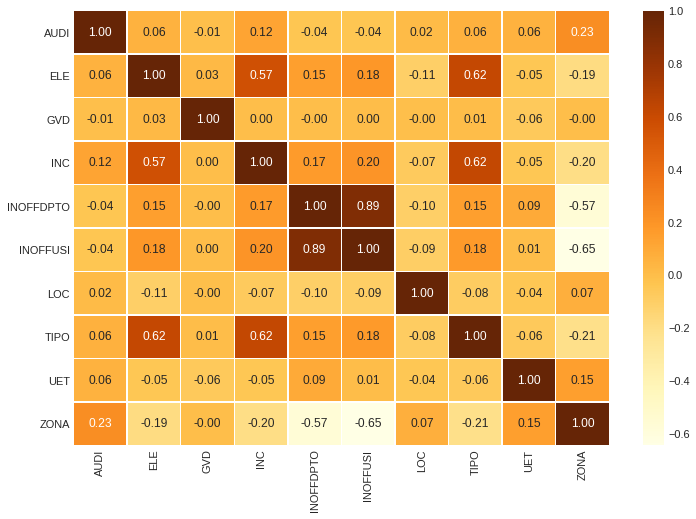

In [ ]:
sns.heatmap(corrmatrix, annot=True, cmap='YlOrBr', fmt='.2f', linewidths=.5)

- Observamos que para predecir **TIPO** solo con **ELE** y **INC** sería suficiente, el resto de variables se descartan debido a que tienen naturaleza temporal o esas *features* no están disponibles.
- En cambio para **UET**, también podriamos agregar **GVD** y **TIPO**.

# **Preparación del dataset**

Se prepara el dataset con las *features* que alimentarán nuestro modelo para ser entrenado.

In [117]:
target = 'UET'
orig_cols = ['ELE','INC', 'LOC', target]

# Dataset setup
dataset = df[orig_cols].fillna({'LOC':'-'}).dropna().astype(str)

# Choose if full-dataset or sample-dataset is used for model training
full = True
times = 40

# Seed for random-state
seed = 42

In [118]:
if not full:
  dataset = dataset.sample(len(dataset)//times, random_state=seed)

In [119]:

y = dataset.pop(target)
X = dataset

In [120]:
cols = list(X.columns)

In [121]:
print(f"Dataset size: {len(dataset)}")

Dataset size: 228882


# **Entrenamiento de los modelos**
Se seleccionaron 8 clasificadores de la librería *scikit-learn* de los cúales luego se hará validación cruzada de *k-folds* para determinar cúal es el mejor.

In [122]:
import time

n_folds = 10
scoring = 'accuracy'

np.random.seed(seed)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score

# Preprocessors
categorical_features = cols
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

# Estimators
classifiers = [
    #KNeighborsClassifier(),
    #SGDClassifier(),
    #RidgeClassifier(),
    #LogisticRegression(),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #XGBClassifier(),
    DecisionTreeClassifier(),
    #RandomForestClassifier(),
    #BaggingClassifier(),
    #SVC(),
    #MLPClassifier(),
    ]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=seed)

clfs = []
names = []
results = []
times = []

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
for classifier in classifiers:
  # Compute start time
  start = time.time()

  #Create pipeline
  clf = Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', classifier)])
  
  clf.fit(X_train, y_train)

  # Add classifier to list of classifiers
  clfs.append(clf)

  # Compute finish time
  total_time=(time.time()-start)
  times.append(total_time)

  # Classifier name
  name = classifier.__class__.__name__
  names.append(name)

  # Compute results of model
  kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
  cv_results = cross_val_score(clf, X_train, y_train, 
                                cv= kfold, scoring=scoring,
                                n_jobs=-1)
  results.append(cv_results)
  
  msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
  print(msg)

DecisionTreeClassifier: 0.794216 (+/- 0.002983)


In [102]:
import re

acronames = []

# Get uppercase for acronyms of classifiers
for classifier in classifiers:
  acroname = re.sub('[^A-Z]', '', str(classifier))
  acronames.append(acroname)

In [75]:
# DataFrame for plotting

perfdf = pd.DataFrame(np.array(results)[:,0], index=acronames, columns=['perf'])
timesdf = pd.DataFrame(times, index=acronames, columns=['times'])
pltdf = timesdf.join(perfdf)
pltdf['perfpertime'] = pltdf.perf / pltdf.times

In [76]:
# Save results
pltdf.to_csv(f'{target}.csv')

## Plot tiempo de ejecución vs performance
Gráfico de barras con doble eje-y para comparar y obtener el mejor clasificador con el menor tiempo de entrenamiento.

Text(0, 0.5, 'performance')

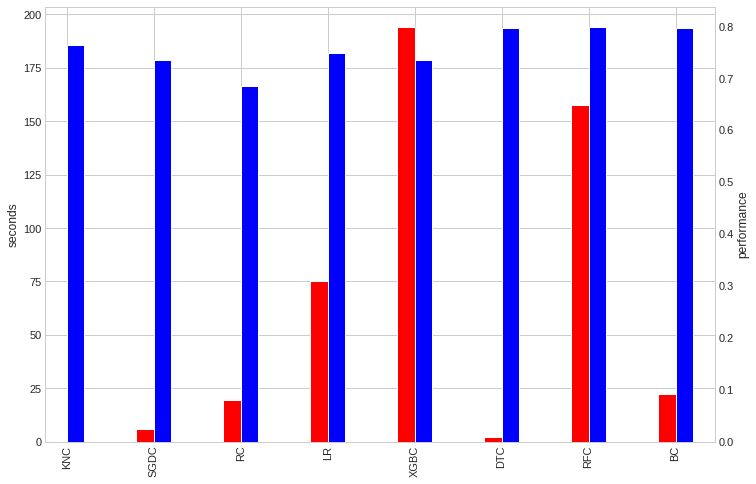

In [83]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.2

pltdf.times.plot(kind='bar', color='red', ax=ax, width=width, position=1, grid=True, figsize=(12,8))
pltdf.perf.plot(kind='bar', color='blue', ax=ax2, width=width, position=0, grid=False)

ax.set_ylabel('seconds')
ax2.set_ylabel('performance')

## Plot rendimiento del modelo
Diagrama de cajas representativo de la validación cruzada de *k-folds*, útil para decidir cúal es el mejor modelo.

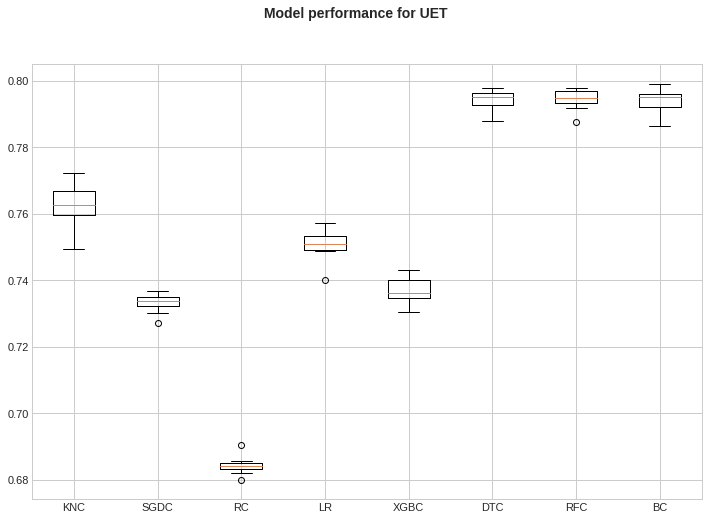

In [78]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (12,8)

# figure related code
fig = plt.figure()
fig.suptitle(f'Model performance for {target}', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(x=results, labels=acronames)

plt.show()

## Guardar modelos
Una vez entrenados los modelos se procede a guardarlos para no tener que reentrenarlos. También se guarda el mejor modelo.

In [79]:
def best_model(results):
  first_col = np.array(results)[:,0]
  index = np.argmax(first_col)
  return index

In [80]:
from joblib import dump, load

In [81]:
# Paths
models_path = os.path.join(MODELS, f'models_{target}.joblib')
bestmodel_path = os.path.join(MODELS, f'bestmodel_{target}.joblib')

# Save all models
dump(clfs, models_path)
print('Models saved [OK]')

# Save best model
best_clf = clfs[best_model(results)]
dump(best_clf, bestmodel_path)
print('Best model saved [OK]')

Models saved [OK]
Best model saved [OK]


In [82]:
pltdf

,times,perf,perfpertime
KNC,0.423867,0.764459,1.803536
SGDC,6.013939,0.733876,0.122029
RC,19.452225,0.685435,0.035237
LR,74.984729,0.748839,0.009987
XGBC,193.920632,0.735241,0.003791
DTC,2.288291,0.795970,0.347845
RFC,157.461613,0.797444,0.005064
BC,22.361360,0.796133,0.035603


# Carga de modelos
A partir de este punto si los modelos ya han sido entrenados pueden ser cargados directamente.

In [128]:
from joblib import load
import os
MODELS = 'models/'
target = 'TIPO'

# Paths
models_path = os.path.join(MODELS, f'models_{target}.joblib')
bestmodel_path = os.path.join(MODELS, f'bestmodel_{target}.joblib')

#clfs = load(models_path)
best_clf = load(bestmodel_path) 

# **Imputation TIPO**
Se imputa la feature en el *df*.

In [129]:
cols = ['ELE','INC']

In [130]:
#prueba = df[df[target].isna()].sample(30)[cols]
#prueba = prueba.fillna({'LOC':'-'}).dropna().astype(str)
#(X_train.iloc[0]).to_frame().transpose()
#best_clf.predict((X_train.iloc[0]).to_frame().transpose())
#prueba.iloc[0].to_frame().transpose()
#test = df[orig_cols].fillna({'LOC':'-'}).astype(str).replace('nan', np.nan)
#test

In [131]:
def predict(row, clf):
  # Check if target is null.
  # If true then predict. Else return original
  if pd.isnull(row[target]):
    prediction = clf.predict(row[cols].to_frame().transpose())
    return ''.join(prediction)
  else:
    return row[target]

In [134]:
df[target] = df.apply(lambda row: predict(row, best_clf), axis=1)

In [135]:
df.head()

,AUDI,DECL,DPTO,ELE,GVD,INC,INOFFDPTO,INOFFUSI,LOC,MADU,PJI,RETO,TALL,TIPO,UET,ZONA
0,CAPS,2020-01-27 09:00:00.000000,NaN,4120,V2,180,NaN,NaN,NaN,NaN,655200530232,NaN,NaN,MOP,NaN,NaN
1,CAPS,2020-01-27 09:00:00.000000,NaN,4466,V2,1010,NaN,NaN,NaN,NaN,655200420197,NaN,NaN,MOP,NaN,NaN
2,CAPS,2020-01-27 09:00:00.000000,NaN,4420,V2,1110,NaN,NaN,NaN,NaN,655200450172,NaN,NaN,ASP,NaN,NaN
3,CAPS,2020-01-27 09:00:00.000000,NaN,4412,V2,1180,NaN,NaN,NaN,NaN,655200450172,NaN,NaN,ASP,NaN,NaN
4,CAPS,2020-01-27 09:00:00.000000,NaN,4414,V2,1270,NaN,NaN,NaN,NaN,655200420197,NaN,NaN,ASP,NaN,NaN


## **Imputacion UET**

In [138]:
from joblib import load
import os
MODELS = 'models/'
target = 'UET'

# Paths
models_path = os.path.join(MODELS, f'models_{target}.joblib')
bestmodel_path = os.path.join(MODELS, f'bestmodel_{target}.joblib')

#clfs = load(models_path)
best_clf = load(bestmodel_path) 

In [139]:
cols = ['ELE','INC','LOC']
target = 'UET'

In [141]:
df = df.fillna({'LOC':'-'}).astype(str).replace('nan', np.nan)
df.head()

,AUDI,DECL,DPTO,ELE,GVD,INC,INOFFDPTO,INOFFUSI,LOC,MADU,PJI,RETO,TALL,TIPO,UET,ZONA
0,CAPS,2020-01-27 09:00:00.000000,NaN,4120,V2,180,NaN,NaN,-,NaN,655200530232,NaN,NaN,MOP,NaN,NaN
1,CAPS,2020-01-27 09:00:00.000000,NaN,4466,V2,1010,NaN,NaN,-,NaN,655200420197,NaN,NaN,MOP,NaN,NaN
2,CAPS,2020-01-27 09:00:00.000000,NaN,4420,V2,1110,NaN,NaN,-,NaN,655200450172,NaN,NaN,ASP,NaN,NaN
3,CAPS,2020-01-27 09:00:00.000000,NaN,4412,V2,1180,NaN,NaN,-,NaN,655200450172,NaN,NaN,ASP,NaN,NaN
4,CAPS,2020-01-27 09:00:00.000000,NaN,4414,V2,1270,NaN,NaN,-,NaN,655200420197,NaN,NaN,ASP,NaN,NaN


In [142]:
df[target] = df.apply(lambda row: predict(row, best_clf), axis=1)

In [143]:
df.head()

,AUDI,DECL,DPTO,ELE,GVD,INC,INOFFDPTO,INOFFUSI,LOC,MADU,PJI,RETO,TALL,TIPO,UET,ZONA
0,CAPS,2020-01-27 09:00:00.000000,NaN,4120,V2,180,NaN,NaN,-,NaN,655200530232,NaN,NaN,MOP,431,NaN
1,CAPS,2020-01-27 09:00:00.000000,NaN,4466,V2,1010,NaN,NaN,-,NaN,655200420197,NaN,NaN,MOP,484,NaN
2,CAPS,2020-01-27 09:00:00.000000,NaN,4420,V2,1110,NaN,NaN,-,NaN,655200450172,NaN,NaN,ASP,483,NaN
3,CAPS,2020-01-27 09:00:00.000000,NaN,4412,V2,1180,NaN,NaN,-,NaN,655200450172,NaN,NaN,ASP,484,NaN
4,CAPS,2020-01-27 09:00:00.000000,NaN,4414,V2,1270,NaN,NaN,-,NaN,655200420197,NaN,NaN,ASP,486,NaN


## Completar departamento y taller
Algoritmo para completar el departamento y taller debido a la estructura jerárquica de la usina.

In [147]:
MISC = 'misc/'
hiepath = os.path.join(MISC, 'hierarchy.xlsx')
print(hiepath)

misc/hierarchy.xlsx


In [154]:
# Load hierarchy data
hie = pd.read_excel(hiepath, 'Datos')
hie.drop(columns=['DPTO', 'TALL', 'UET'], inplace=True)
hie.rename(columns={'DPTOACRO':'DPTO','TALLACRO':'TALL','UETACRO':'UET'}, inplace=True)

In [156]:
hie['DPTO'] = hie['DPTO'].astype(str)
hie['TALL'] = hie['TALL'].astype(str)
hie['UET'] = hie['UET'].astype(str)

In [157]:
hie['DPTO'].replace({'DCHAP':'SOLD', 'DPINT':'PINT', 'EMB ':'EMBU', 'DMONT':'MONT', 'MONTVU ':'MONT', 'CALID':'CALI'}, inplace=True)

In [158]:
# Completar TALL en función a la UET
def fill_taller(uet):
    hieuet = hie.copy()
    hieuet.set_index('UET', inplace=True)
    try:
        return hieuet.loc[uet].TALL
    except:
        pass

# Completar DPTO en función al TALL
def fill_dpto(tall):
    hietall = hie.copy()
    hietall = hietall.drop(columns='UET').drop_duplicates(subset='TALL')
    hietall.set_index('TALL', inplace=True)
    try:
        return hietall.loc[tall].DPTO
    except:
        pass

In [159]:
df['TALL'] = df.apply(lambda row: fill_taller(row['UET']), axis=1)
df['DPTO'] = df.apply(lambda row: fill_dpto(row['TALL']), axis=1)

,AUDI,DECL,DPTO,ELE,GVD,INC,INOFFDPTO,INOFFUSI,LOC,MADU,PJI,RETO,TALL,TIPO,UET,ZONA
0,CAPS,2020-01-27 09:00:00.000000,NaN,4120,V2,180,NaN,NaN,-,NaN,655200530232,NaN,TOLE4,MOP,431,NaN
1,CAPS,2020-01-27 09:00:00.000000,NaN,4466,V2,1010,NaN,NaN,-,NaN,655200420197,NaN,PTAL2,MOP,484,NaN
2,CAPS,2020-01-27 09:00:00.000000,NaN,4420,V2,1110,NaN,NaN,-,NaN,655200450172,NaN,PTAL2,ASP,483,NaN
3,CAPS,2020-01-27 09:00:00.000000,NaN,4412,V2,1180,NaN,NaN,-,NaN,655200450172,NaN,PTAL2,ASP,484,NaN
4,CAPS,2020-01-27 09:00:00.000000,NaN,4414,V2,1270,NaN,NaN,-,NaN,655200420197,NaN,PTAL2,ASP,486,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235533,PESD,2020-12-30 09:06:00,PINT,4502,V2,1000,NaN,NaN,GRAL,NaN,655210140012,NaN,SERVP,ASP,DIP,PESD
235534,PESD,2020-12-30 10:03:00,SOLD,7887,V2,3220,NaN,NaN,-,NaN,655210140033,NaN,TOLE4,GMTR,659,PESD
235535,PESD,2020-12-30 10:03:00,MONT,5215,V2,4450,NaN,NaN,K74,NaN,655210140033,NaN,CH-ME,NCON,654,PESD
235536,PESD,2020-12-30 10:03:00,PINT,4401,V2,1190,NaN,NaN,H54,NaN,655210140033,NaN,PTAL2,ASP,483,PESD


In [163]:
# Save imputed data
DATAIMP = os.path.join(DATADIR, '2020_imp.csv')
df.to_csv(DATAIMP)

In [162]:
df

,AUDI,DECL,DPTO,ELE,GVD,INC,INOFFDPTO,INOFFUSI,LOC,MADU,PJI,RETO,TALL,TIPO,UET,ZONA
0,CAPS,2020-01-27 09:00:00.000000,SOLD,4120,V2,180,NaN,NaN,-,NaN,655200530232,NaN,TOLE4,MOP,431,NaN
1,CAPS,2020-01-27 09:00:00.000000,PINT,4466,V2,1010,NaN,NaN,-,NaN,655200420197,NaN,PTAL2,MOP,484,NaN
2,CAPS,2020-01-27 09:00:00.000000,PINT,4420,V2,1110,NaN,NaN,-,NaN,655200450172,NaN,PTAL2,ASP,483,NaN
3,CAPS,2020-01-27 09:00:00.000000,PINT,4412,V2,1180,NaN,NaN,-,NaN,655200450172,NaN,PTAL2,ASP,484,NaN
4,CAPS,2020-01-27 09:00:00.000000,PINT,4414,V2,1270,NaN,NaN,-,NaN,655200420197,NaN,PTAL2,ASP,486,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235533,PESD,2020-12-30 09:06:00,PINT,4502,V2,1000,NaN,NaN,GRAL,NaN,655210140012,NaN,SERVP,ASP,DIP,PESD
235534,PESD,2020-12-30 10:03:00,SOLD,7887,V2,3220,NaN,NaN,-,NaN,655210140033,NaN,TOLE4,GMTR,659,PESD
235535,PESD,2020-12-30 10:03:00,MONTVU,5215,V2,4450,NaN,NaN,K74,NaN,655210140033,NaN,CH-ME,NCON,654,PESD
235536,PESD,2020-12-30 10:03:00,PINT,4401,V2,1190,NaN,NaN,H54,NaN,655210140033,NaN,PTAL2,ASP,483,PESD
